<a href="https://colab.research.google.com/github/chaen243/SeSAC_colab/blob/main/03_01_MNIST_NN_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
your_path = "/content/"
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir(your_path)
    print(os.getcwd())
except ModuleNotFoundError:
    print("you are not in google colab, pass this phase")
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Neural Network with MNIST

## torchvision 패키지

torchvision 은 컴퓨터 비전과 관련된 유틸들을 모아둔 패키지다.

In [ ]:
# 데이터 경로
data_path = "../data"

train_dataset = datasets.MNIST(
    root=data_path,
    train=True,
    transform=transforms.ToTensor(),
    download=True)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True)

test_dataset = datasets.MNIST(
    root=data_path,
    train=False,
    transform=transforms.ToTensor(),
    download=True)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=True)



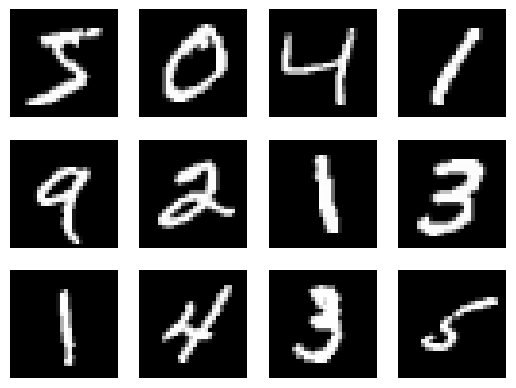

In [ ]:
fig, axes = plt.subplots(3, 4)
img_tensors = train_dataset.data[:12]
for ax, img in zip(axes.flatten(), img_tensors):
    ax.imshow(img, cmap="gray")
    ax.axis("off")

## MNIST 모델(Coding Part)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### **네트워크 설계**

**1. 다음의 구조를 참고하여 Network 클래스를 완성하시오.**

* Input Size = (B, 1, 28, 28)
* Output Size = (B, 10)
* Linear Layer 1(`nn.Linear`): Hidden size = 300  
* Linear Layer 2(`nn.Linear`): Hidden size = 100
* Activation Function(`nn.ReLU`): ReLU
* Loss Function(`nn.CrossEntropyLoss`): Cross Entropy Loss
* Optimizer(`optim.Adam`): Adam

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # 층을 구성
        """write your code"""
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)


    def forward(self, x):
        # forward propagation 수행
        # x의 차원을 (미니배치, 28*28)에 알맞게 수정한다.
        x = x.view(-1, 784)
        """write your code"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### **손실함수 및 옵티마이저**

** 2. loss function과 optimizer를 선택하시오 **


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 커스텀 모듈 호출
model = Network().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

## 모델 훈련

훈련 데이터로 모델을 훈련시키고, 테스트 데이터로 최적의 모델을 결정한다.

In [ ]:
train_data, train_labels = next(iter(train_loader))
test_data, test_labels = next(iter(test_loader))
# 차원 변환 과정 (모델을 돌리기 위해서 2차원으로 변경)
train_dataset = train_data.view(train_data.shape[0], -1)  # (60000, 1, 28, 28) -> (60000, 784) #-1 = 선택되지 않은값들을 전부 곱해줌
test_dataset = test_data.view(test_data.shape[0], -1)  # (10000, 1, 28, 28) -> (10000, 784)

In [ ]:
n_train = len(train_dataset)
n_test = len(test_dataset)
n_step = 10
print_step = 300
best_accuracy = 0

for step in range(n_step):
    print(f"[Step] {step+1}/{n_step}\n [Training Step]")
    # Training
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # 입력과 타겟 텐서에 GPU 를 사용여부 전달
        data, target = data.to(device), target.to(device)
        # 경사 초기화
        # model.eval()
        # 순방향 전파
        output = model(data)
        # 손실값 계산
        loss = loss_function(output, target)
        # 역방향 전파
        loss.backward()
        # 매개변수 업데이트
        optimizer.step()
        # 중간 과정 print
        if batch_idx % print_step == 0:
            percentage = (batch_idx*64 / n_train) * 100
            print(f" - [{percentage:.2f}%] train loss: {loss.item():.4f}")

    # Validation
    model.eval()
    test_loss = 0
    correct = 0
    # torch.no_grad 를 사용하면 requires_grad 를 꺼두게 된다.
    with torch.no_grad():
        for data, target in test_loader:
            # 입력과 타겟 텐서에 GPU 를 사용여부 전달
            data, target = data.to(device), target.to(device)
            # 순방향전파
            output = model(data)
            # 손실값 계산
            test_loss += loss_function(output, target).item()
            # 예측 값에 해당하는 클래스 번호 반환
            pred = torch.argmax(output, dim=1)
            # 정확하게 예측한 개수를 기록한다
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_accuracy = correct / n_test
    print(f" [Validation Step]")
    print(f" - test loss: {test_loss:.4f} test accuracy: {test_accuracy*100:.2f} %")

    # 제일 성능을 보인 좋은 모델 저장하기
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), "best_model-mnist.pt")


## 이미지를 그려보고 테스트 해보자!

In [ ]:
load_path = "best_model-mnist.pt"
model = Network()
model.load_state_dict(torch.load(load_path))

def predict(model, x):
    model.eval()
    output = model(x)
    pred = torch.argmax(output, dim=1)
    print(f"Predict Number is {pred.item()}")

<ipython-input-49-4f3bce1b94e5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


In [ ]:
try:
    from google.colab.output import eval_js
    from IPython.display import HTML, Image
    from base64 import b64decode
except ModuleNotFoundError:
    print("only support in google colabotory")

In [ ]:
canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=480, h=480, line_width=25):
    display(HTML(canvas_html % (w, h, line_width)))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    from PIL import Image
    import numpy as np
    img = Image.open(filename)
    img.thumbnail((28, 28), Image.Resampling.LANCZOS)
    x = np.array(img)[:, :, -1]
    img = Image.fromarray(x)
    img.save(filename)
    print(f"'{filename}' image saved!")

def load_image(filename="drawing.png"):
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt
    img = Image.open(filename)
    x = np.array(img) / 255.0
    plt.imshow(x)
    plt.show()
    return x[np.newaxis, np.newaxis, :, :]

In [ ]:
draw(filename='custom_drawing.png')

NameError: name 'draw' is not defined

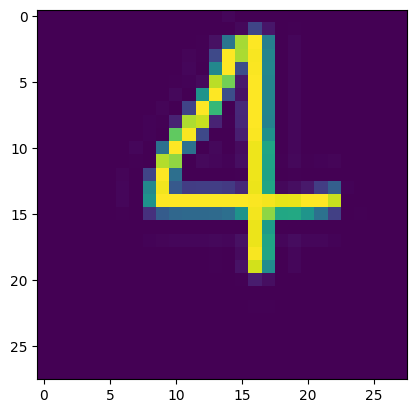

Predict Number is 6


In [ ]:
x = load_image(filename='custom_drawing.png')
x = torch.FloatTensor(x)
predict(model, x)